<a href="https://colab.research.google.com/github/Aniket23160/SelfDriving_BITSPilani/blob/main/2D_SLAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline


In [2]:
# the robot class
class robot:

    # --------
    # init: 
    #   creates a robot with the specified parameters and initializes 
    #   the location (self.x, self.y) to the center of the world
    #
    def __init__(self, world_size = 100.0, measurement_range = 30.0,
                 motion_noise = 1.0, measurement_noise = 1.0):
        self.measurement_noise = 0.0
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.x = world_size / 2.0
        self.y = world_size / 2.0
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.landmarks = []
        self.num_landmarks = 0


    # returns a positive, random float
    def rand(self):
        return random.random() * 2.0 - 1.0


    # --------
    # move: attempts to move robot by dx, dy. If outside world
    #       boundary, then the move does nothing and instead returns failure
    #
    def move(self, dx, dy):

        x = self.x + dx + self.rand() * self.motion_noise
        y = self.y + dy + self.rand() * self.motion_noise

        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True
    

    # --------
    # sense: returns x- and y- distances to landmarks within visibility range
    #        because not all landmarks may be in this range, the list of measurements
    #        is of variable length. Set measurement_range to -1 if you want all
    #        landmarks to be visible at all times
    #
    
    ## TODO: complete the sense function
    def sense(self):
        ''' This function does not take in any parameters, instead it references internal variables
            (such as self.landamrks) to measure the distance between the robot and any landmarks
            that the robot can see (that are within its measurement range).
            This function returns a list of landmark indices, and the measured distances (dx, dy)
            between the robot's position and said landmarks.
            This function should account for measurement_noise and measurement_range.
            One item in the returned list should be in the form: [landmark_index, dx, dy].
            '''
           
        measurements = []
        
        ## TODO: iterate through all of the landmarks in a world
        
        ## TODO: For each landmark
        ## 1. compute dx and dy, the distances between the robot and the landmark
        ## 2. account for measurement noise by *adding* a noise component to dx and dy
        ##    - The noise component should be a random value between [-1.0, 1.0)*measurement_noise
        ##    - Feel free to use the function self.rand() to help calculate this noise component
        ##    - It may help to reference the `move` function for noise calculation
        ## 3. If either of the distances, dx or dy, fall outside of the internal var, measurement_range
        ##    then we cannot record them; if they do fall in the range, then add them to the measurements list
        ##    as list.append([index, dx, dy]), this format is important for data creation done later
        
        ## TODO: return the final, complete list of measurements
        for landmark_index, landmark in enumerate(self.landmarks):
            landmark_distance_x = landmark[0]
            landmark_distance_y = landmark[1]
            random_noise = self.rand()
            cal_dx = self.x - landmark_distance_x + random_noise * self.measurement_noise
            cal_dy = self.y - landmark_distance_y + random_noise * self.measurement_noise
            is_not_in_measurement_range = self.measurement_range == -1
            if(is_not_in_measurement_range) or ((abs(cal_dx) <= self.measurement_range) and (abs(cal_dy) <= self.measurement_range)):
                measurements.append([landmark_index, cal_dx, cal_dy])
        return measurements

    
    # --------
    # make_landmarks: 
    # make random landmarks located in the world
    #
    def make_landmarks(self, num_landmarks):
        self.landmarks = []
        for i in range(num_landmarks):
            self.landmarks.append([round(random.random() * self.world_size),
                                   round(random.random() * self.world_size)])
        self.num_landmarks = num_landmarks
    
    
    # called when print(robot) is called; prints the robot's location
    def __repr__(self):
        return 'Robot: [x=%.5f y=%.5f]'  % (self.x, self.y)


In [3]:
world_size         = 10.0    # size of world (square)
measurement_range  = 5.0     # range at which we can sense landmarks
motion_noise       = 0.2      # noise in robot motion
measurement_noise  = 0.2      # noise in the measurements

# instantiate a robot, r
r = robot(world_size, measurement_range, motion_noise, measurement_noise)

# print out the location of r
print(r)


Robot: [x=5.00000 y=5.00000]


In [5]:
# from robot_class import robot
from math import *
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# --------
# this helper function displays the world that a robot is in
# it assumes the world is a square grid of some given size
# and that landmarks is a list of landmark positions(an optional argument)
def display_world(world_size, position, landmarks=None):
    
    # using seaborn, set background grid to gray
    sns.set_style("dark")

    # Plot grid of values
    world_grid = np.zeros((world_size+1, world_size+1))

    # Set minor axes in between the labels
    ax=plt.gca()
    cols = world_size+1
    rows = world_size+1

    ax.set_xticks([x for x in range(1,cols)],minor=True )
    ax.set_yticks([y for y in range(1,rows)],minor=True)
    
    # Plot grid on minor axes in gray (width = 1)
    plt.grid(which='minor',ls='-',lw=1, color='white')
    
    # Plot grid on major axes in larger width
    plt.grid(which='major',ls='-',lw=2, color='white')
    
    # Create an 'o' character that represents the robot
    # ha = horizontal alignment, va = vertical
    ax.text(position[0], position[1], 'o', ha='center', va='center', color='r', fontsize=30)
    
    # Draw landmarks if they exists
    if(landmarks is not None):
        # loop through all path indices and draw a dot (unless it's at the car's location)
        for pos in landmarks:
            if(pos != position):
                ax.text(pos[0], pos[1], 'x', ha='center', va='center', color='purple', fontsize=20)
    
    # Display final result
    plt.show()

    
# --------
# this routine makes the robot data
# the data is a list of measurements and movements: [measurements, [dx, dy]]
# collected over a specified number of time steps, N
#
def make_data(N, num_landmarks, world_size, measurement_range, motion_noise, 
              measurement_noise, distance):

    # check that data has been made
    try:
        check_for_data(num_landmarks, world_size, measurement_range, motion_noise, measurement_noise)
    except ValueError:
        print('Error: You must implement the sense function in robot_class.py.')
        return []
    
    complete = False
    
    r = robot(world_size, measurement_range, motion_noise, measurement_noise)
    r.make_landmarks(num_landmarks)

    while not complete:

        data = []

        seen = [False for row in range(num_landmarks)]
    
        # guess an initial motion
        orientation = random.random() * 2.0 * pi
        dx = cos(orientation) * distance
        dy = sin(orientation) * distance
            
        for k in range(N-1):
    
            # collect sensor measurements in a list, Z
            Z = r.sense()

            # check off all landmarks that were observed 
            for i in range(len(Z)):
                seen[Z[i][0]] = True
    
            # move
            while not r.move(dx, dy):
                # if we'd be leaving the robot world, pick instead a new direction
                orientation = random.random() * 2.0 * pi
                dx = cos(orientation) * distance
                dy = sin(orientation) * distance

            # collect/memorize all sensor and motion data
            data.append([Z, [dx, dy]])

        # we are done when all landmarks were observed; otherwise re-run
        complete = (sum(seen) == num_landmarks)

    print(' ')
    print('Landmarks: ', r.landmarks)
    print(r)


    return data


def check_for_data(num_landmarks, world_size, measurement_range, motion_noise, measurement_noise):
    # make robot and landmarks
    r = robot(world_size, measurement_range, motion_noise, measurement_noise)
    r.make_landmarks(num_landmarks)
    
    
    # check that sense has been implemented/data has been made
    test_Z = r.sense()
    if(test_Z is None):
        raise ValueError


Robot: [x=5.00000 y=5.00000]


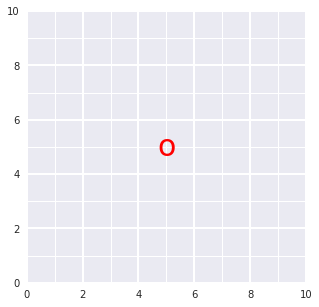

In [6]:
# from helpers import display_world

# define figure size
plt.rcParams["figure.figsize"] = (5,5)

# call display_world and display the robot in it's grid world
print(r)
display_world(int(world_size), [r.x, r.y])


Robot: [x=6.17024 y=6.97143]


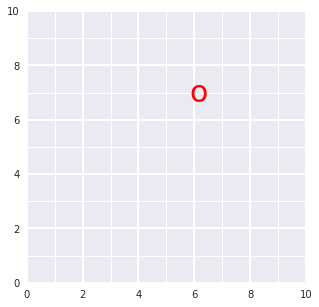

In [7]:
dx = 1
dy = 2
r.move(dx, dy)

# print out the exact location
print(r)

# display the world after movement, not that this is the same call as before
# the robot tracks its own movement
display_world(int(world_size), [r.x, r.y])


Robot: [x=6.17024 y=6.97143]


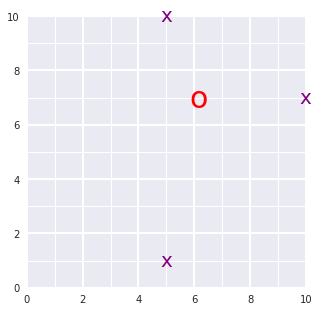

Landmark locations [x,y]:  [[5, 10], [10, 7], [5, 1]]


In [8]:
num_landmarks = 3
r.make_landmarks(num_landmarks)

# print out our robot's exact location
print(r)

# display the world including these landmarks
display_world(int(world_size), [r.x, r.y], r.landmarks)

# print the locations of the landmarks
print('Landmark locations [x,y]: ', r.landmarks)


In [9]:
measurements = r.sense()

# this will print out an empty list if `sense` has not been implemented
print(measurements)


[[0, 1.0540731333359044, -3.1447311235764928], [1, -3.7209958695799887, 0.08019987350761429]]


In [10]:
data = []

# after a robot first senses, then moves (one time step)
# that data is appended like so:
data.append([measurements, [dx, dy]])

# for our example movement and measurement
print(data)


[[[[0, 1.0540731333359044, -3.1447311235764928], [1, -3.7209958695799887, 0.08019987350761429]], [1, 2]]]


In [11]:
time_step = 0

# so you can access robot measurements:
print('Measurements: ', data[time_step][0])

# and its motion for a given time step:
print('Motion: ', data[time_step][1])


Measurements:  [[0, 1.0540731333359044, -3.1447311235764928], [1, -3.7209958695799887, 0.08019987350761429]]
Motion:  [1, 2]


In [12]:
import numpy as np

# define omega and xi as in the example
omega = np.array([[1,0,0],
                  [-1,1,0],
                  [0,-1,1]])

xi = np.array([[-3],
               [5],
               [3]])

# calculate the inverse of omega
omega_inv = np.linalg.inv(np.matrix(omega))

# calculate the solution, mu
mu = omega_inv*xi

# print out the values of mu (x0, x1, x2)
print(mu)


[[-3.]
 [ 2.]
 [ 5.]]


In [13]:
import numpy as np
# from helpers import make_data

# your implementation of slam should work with the following inputs
# feel free to change these input values and see how it responds!

# world parameters
num_landmarks      = 5        # number of landmarks
N                  = 20       # time steps
world_size         = 100.0    # size of world (square)

# robot parameters
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation 


# make_data instantiates a robot, AND generates random landmarks for a given world size and number of landmarks
data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)


 
Landmarks:  [[92, 1], [54, 70], [46, 21], [31, 84], [79, 33]]
Robot: [x=21.87740 y=32.22002]


In [14]:
time_step = 0

print('Example measurements: \n', data[time_step][0])
print('\n')
print('Example motion: \n', data[time_step][1])


Example measurements: 
 [[0, -41.909683443445374, 49.090316556554626], [1, -5.6998238625899145, -21.699823862589916], [2, 5.361413895364775, 30.361413895364777], [3, 20.422849095972914, -32.577150904027086], [4, -27.96436172413456, 18.03563827586544]]


Example motion: 
 [-19.508396942459786, -4.407090733740987]


In [15]:
def initialize_constraints(N, num_landmarks, world_size):
    ''' This function takes in a number of time steps N, number of landmarks, and a world_size,
        and returns initialized constraint matrices, omega and xi.'''
    
    middle_of_the_world = world_size / 2
    
    ## Recommended: Define and store the size (rows/cols) of the constraint matrix in a variable
    rows, cols = 2*(N + num_landmarks), 2*(N + num_landmarks)
    ## TODO: Define the constraint matrix, Omega, with two initial "strength" values
    omega = np.zeros(shape = (rows, cols))
    ## for the initial x, y location of our robot
    #omega = [0]
    
    omega[0][0], omega[1][1] = 1,1
    
    ## TODO: Define the constraint *vector*, xi
    ## you can assume that the robot starts out in the middle of the world with 100% confidence
    #xi = [0]
    xi = np.zeros(shape = (rows, 1))
    xi[0][0] = middle_of_the_world
    xi[1][0] = middle_of_the_world
    
    return omega, xi


In [16]:
N_test = 5
num_landmarks_test = 2
small_world = 10

# initialize the constraints
initial_omega, initial_xi = initialize_constraints(N_test, num_landmarks_test, small_world)


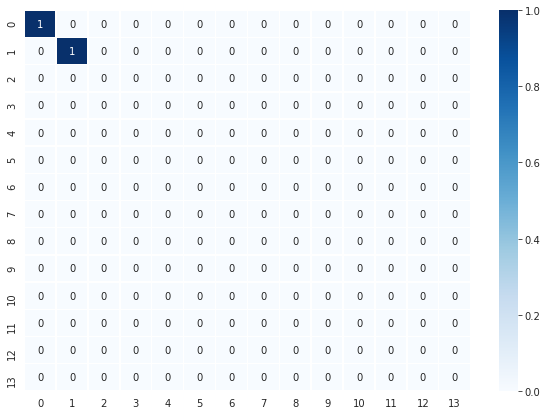

In [18]:
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,7)

# display omega
sns.heatmap(DataFrame(initial_omega), cmap='Blues', annot=True, linewidths=.5)


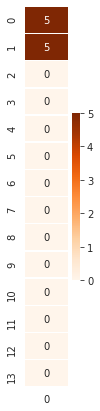

In [19]:
plt.rcParams["figure.figsize"] = (1,7)

# display xi
sns.heatmap(DataFrame(initial_xi), cmap='Oranges', annot=True, linewidths=.5)


In [20]:
def slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise):
    
    ## TODO: Use your initilization to create constraint matrices, omega and xi
    omega, xi = initialize_constraints(N, num_landmarks, world_size)
    ## TODO: Iterate through each time step in the data
    for time_step in range(len(data)):
        
        ## get all the motion and measurement data as you iterate through each time step
        measurement = data[time_step][0]
        motion = data[time_step][1]
        
        dx = motion[0]         # distance to be moved along x in this time_step
        dy = motion[1]         # distance to be moved along y in this time_step
        
        #Consider the robot moves from (x0,y0) to (x1,y1) in this time_step
        
        #even numbered columns of omega correspond to x values
        x0 = (time_step * 2)   #x0 = 0,2,4,...
        x1 = x0 + 2            #x1 = 2,4,6,...
        
        #odd numbered columns of omega correspond to y values
        y0 = x0 + 1            #y0 = 1,3,5,...
        y1 = y0 + 2            #y1 = 3,5,7,...
        
        actual_m_noise = 1.0/measurement_noise
        actual_n_noise = 1.0/motion_noise
    ## TODO: update the constraint matrix/vector(omega/xi) to account for all *measurements*
    ## this should be a series of additions that take into account the measurement noise
        for landmark in measurement:
            lM = landmark[0]            # landmark id
            dx_lM = landmark[1]         # separation along x from current position
            dy_lM = landmark[2]         # separation along y from current position
            
            L_x0 = (N*2) + (lM*2)       # even-numbered columns have x values of landmarks
            L_y0 = L_x0 + 1             # odd-numbered columns have y values of landmarks

            # update omega values corresponding to measurement between x0 and Lx0
            omega[x0][x0] += actual_m_noise
            omega[L_x0][L_x0] += actual_m_noise
            omega[x0][L_x0] += -actual_m_noise
            omega[L_x0][x0] += -actual_m_noise
            
            # update omega values corresponding to measurement between y0 and Ly0
            omega[y0][y0] += actual_m_noise
            omega[L_y0][L_y0] += actual_m_noise
            omega[y0][L_y0] += -actual_m_noise
            omega[L_y0][y0] += -actual_m_noise
            
            # update xi values corresponding to measurement between x0 and Lx0
            xi[x0]  -= dx_lM/measurement_noise
            xi[L_x0]  += dx_lM/measurement_noise
            
            # update xi values corresponding to measurement between y0 and Ly0
            xi[y0]  -= dy_lM/measurement_noise
            xi[L_y0] += dy_lM/measurement_noise
            
            
        ## TODO: update the constraint matrix/vector(omega/xi) to account for all *motion* from from (x0,y0) to (x1,y1) and motion noise
        omega[x0][x0] += actual_n_noise
        omega[x1][x1] += actual_n_noise
        omega[x0][x1] += -actual_n_noise
        omega[x1][x0] += -actual_n_noise
        
        omega[y0][y0] += actual_n_noise
        omega[y1][y1] += actual_n_noise
        omega[y0][y1] += -actual_n_noise
        omega[y1][y0] += -actual_n_noise
        
        xi[x0] -= dx/motion_noise
        xi[y0] -= dy/motion_noise
        
        xi[x1] += dx/motion_noise
        xi[y1] += dy/motion_noise
    
    ## TODO: After iterating through all the data
    ## Compute the best estimate of poses and landmark positions
    ## using the formula, omega_inverse * Xi
    inverse_of_omega = np.linalg.inv(np.matrix(omega))
    mu = inverse_of_omega * xi
    
    return mu # return `mu`


In [21]:
def get_poses_landmarks(mu, N):
    # create a list of poses
    poses = []
    for i in range(N):
        poses.append((mu[2*i].item(), mu[2*i+1].item()))

    # create a list of landmarks
    landmarks = []
    for i in range(num_landmarks):
        landmarks.append((mu[2*(N+i)].item(), mu[2*(N+i)+1].item()))

    # return completed lists
    return poses, landmarks


In [22]:
def print_all(poses, landmarks):
    print('\n')
    print('Estimated Poses:')
    for i in range(len(poses)):
        print('['+', '.join('%.3f'%p for p in poses[i])+']')
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print('['+', '.join('%.3f'%l for l in landmarks[i])+']')


In [23]:
mu = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)

# print out the resulting landmarks and poses
if(mu is not None):
    # get the lists of poses and landmarks
    # and print them out
    poses, landmarks = get_poses_landmarks(mu, N)
    print_all(poses, landmarks)




Estimated Poses:
[50.000, 50.000]
[60.940, 55.572]
[71.224, 64.479]
[73.937, 72.432]
[66.957, 75.801]
[63.347, 84.475]
[51.520, 85.922]
[35.704, 83.314]
[19.687, 81.466]
[8.087, 83.218]
[8.227, 79.418]
[11.098, 76.942]
[20.676, 63.892]
[32.293, 49.818]
[42.912, 35.272]
[56.043, 31.429]
[66.213, 35.013]
[73.874, 44.214]
[75.250, 44.021]
[95.217, 42.860]


Estimated Landmarks:
[7.266, 94.953]
[38.466, 31.145]
[44.745, 74.294]
[61.388, 17.905]
[17.897, 64.934]


Last pose:  (95.21665186494168, 42.85970314086557)


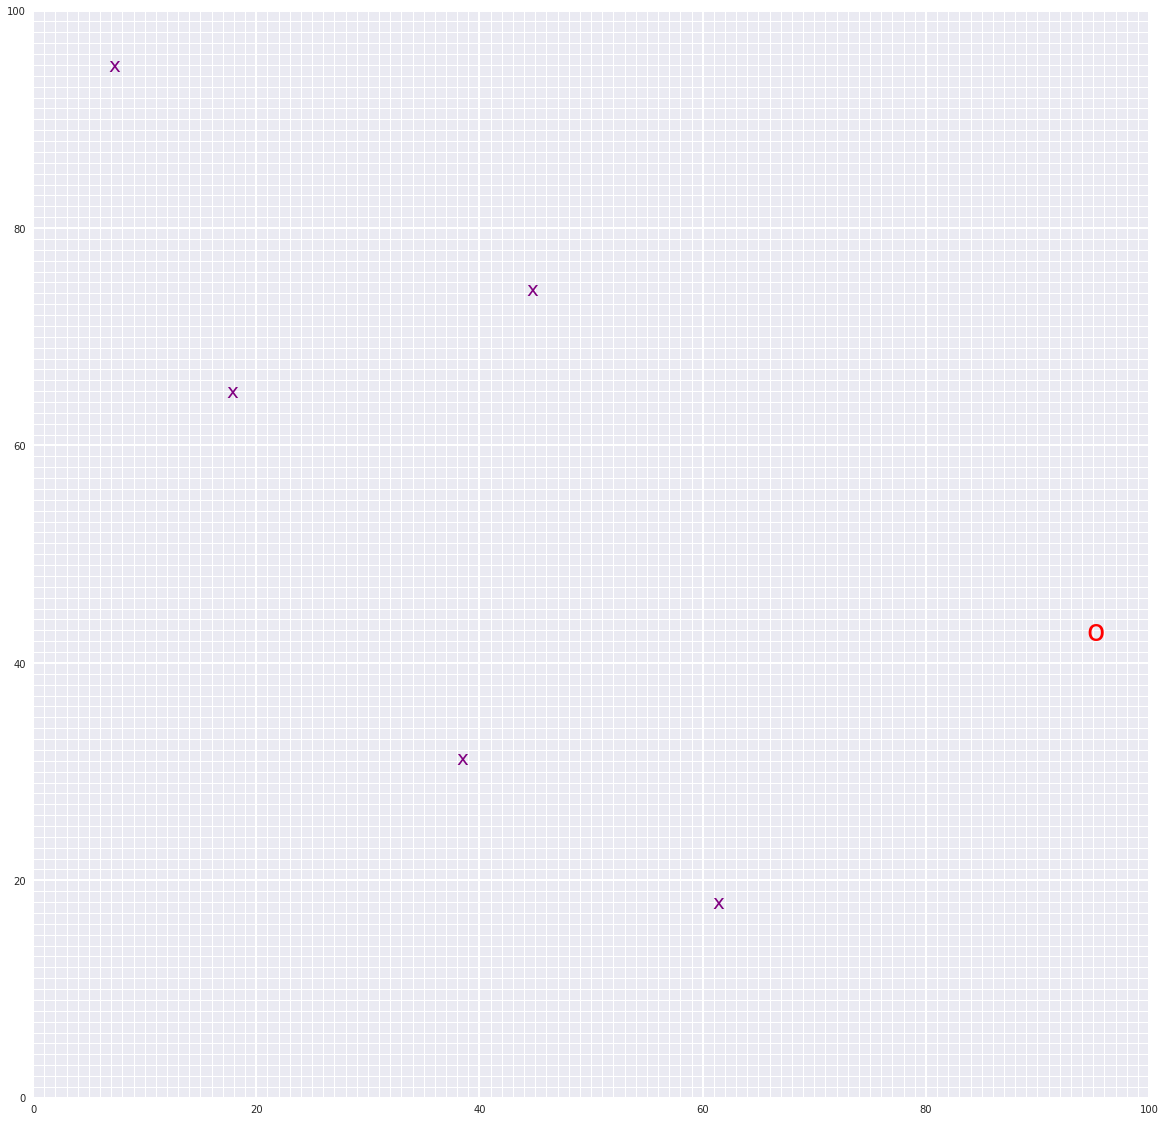

In [24]:
# from helpers import display_world

# Display the final world!

# define figure size
plt.rcParams["figure.figsize"] = (20,20)

# check if poses has been created
if 'poses' in locals():
    # print out the last pose
    print('Last pose: ', poses[-1])
    # display the last position of the robot *and* the landmark positions
    display_world(int(world_size), poses[-1], landmarks)
